This note implements PCA using `np.linalg.svd` and compare the results to sklearn implementation.

# Sklearn implementation

In [1]:
# adopted from https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA, TruncatedSVD

iris = datasets.load_iris()

pca = PCA(n_components=2)
projected_skl = pca.fit(iris.data).transform(iris.data)

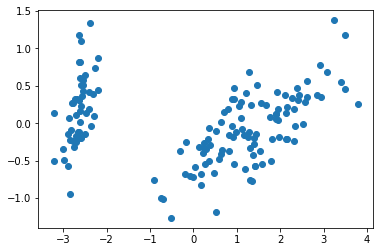

In [2]:
plt.scatter(projected_skl[:, 0], projected_skl[:, 1])

# Custom implementation

In [3]:
X = iris.data.T

In [4]:
X.shape

(4, 150)

In [5]:
n = X.shape[1]

In [6]:
X_tilde = X - X.mean(axis=1).reshape(-1, 1)

In [7]:
# Check data are standardized
np.testing.assert_allclose(X_tilde.sum(axis=1), np.zeros(len(X_tilde)), atol=1e-12)

In [8]:
U, Σ, Vh = np.linalg.svd(1 / np.sqrt(n - 1) * X_tilde, full_matrices=False)

In [9]:
U.shape

(4, 4)

In [10]:
Vh.shape

(4, 150)

In [11]:
# Check eigenvectors are normalized
np.testing.assert_allclose((U**2).sum(axis=1), np.ones(len(X_tilde)), atol=1e-12)

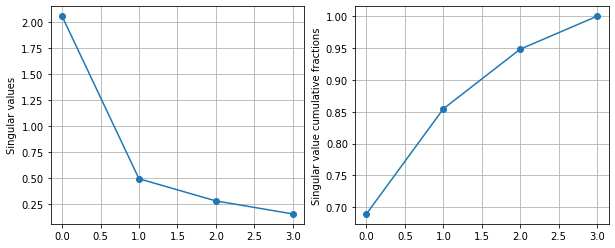

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()

axes[0].plot(Σ, marker='o')
axes[0].set(ylabel='Singular values')
axes[0].grid()

axes[1].plot(np.cumsum(Σ / Σ.sum()), marker='o')
axes[1].set(ylabel='Singular value cumulative fractions')
axes[1].grid()

### Validates the projections of $\tilde{Y}$ match those from sklearn implementation exactly.

In [13]:
# We project both X and \tilde{X} becuase it appears that sklearn implementation projects the later
X_projected = - U[:,:2].T @ X
X_projected_tilde = - U[:,:2].T @ X_tilde

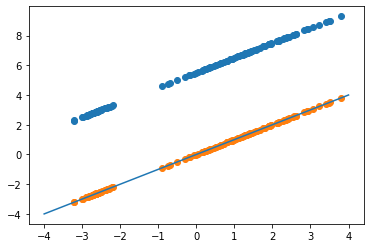

In [14]:
plt.scatter(projected_skl[:,0], X_projected[0])
plt.scatter(projected_skl[:,0], X_projected_tilde[0])
plt.plot([-4, 4], [-4, 4])

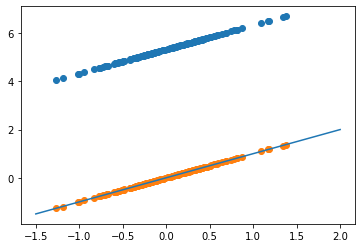

In [15]:
plt.scatter(projected_skl[:,1], X_projected[1])
plt.scatter(projected_skl[:,1], X_projected_tilde[1])
plt.plot([-1.5, 2], [-1.5, 2])

### Validates the variances match those from sklearn implementation.

In [16]:
pca.explained_variance_

array([4.22824171, 0.24267075])

In [17]:
Σ ** 2

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

# Project back to the original space

In [18]:
X_proj_back = - U[:,:2] @ X_projected

In [19]:
np.var(X_proj_back, ddof=1, axis=1).sum()

4.470912453963494

In [20]:
(Σ ** 2)[:2].sum()

4.4709124539634955

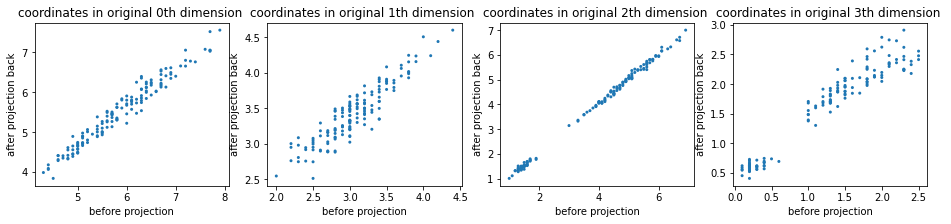

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.scatter(X.T[:, i], X_proj_back.T[:, i], marker=".", edgecolor="none")
    ax.set(
        title=f"coordinates in original {i}th dimension ",
        xlabel="before projection",
        ylabel="after projection back",
    )

This show the difference in coordinate for each data point between before projection and reconstruction (after projecting back to the high-dimensional space).

Then we attribute the lost variance in the last two eigenvalues to the dimensions in the original high-dimensional space.

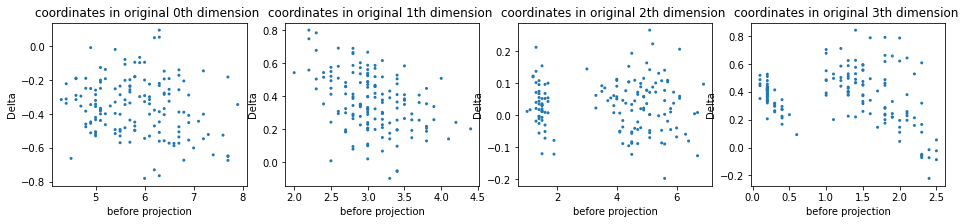

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.scatter(X.T[:, i], X_proj_back.T[:, i] - X.T[:, i], marker=".", edgecolor="none")
    ax.set(
        title=f"coordinates in original {i}th dimension ",
        xlabel="before projection",
        ylabel="Delta",
    )

so the lost variances in the last two eigenvalues are from all four dimension in the original space.

Here, we plot the lost variance in each dimension between after projection back and before projection.

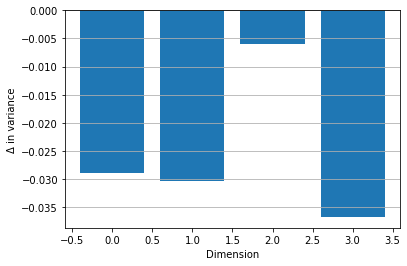

In [23]:
delta_var = np.var(X_proj_back, ddof=1, axis=1) - np.var(X, ddof=1, axis=1) 
plt.bar(range(len(X_proj_back)), delta_var)

plt.xlabel("Dimension")
plt.ylabel("Δ in variance")
plt.grid(axis="y")

In [24]:
delta_var.sum()

-0.10204459301637295

In [25]:
(Σ ** 2)[2:].sum()

0.10204459301636891

### Confirm trace of $X$ is equal to sum of eigenvalues/singular values squared.

In [26]:
np.var(X_tilde, ddof=1, axis=1).sum()

4.572957046979868

In [27]:
np.var(X, ddof=1, axis=1).sum()

4.572957046979867

In [28]:
(Σ ** 2).sum()

4.572957046979864

# On a separate note, verify the working of sklearn TruncatedSVD, which is closely related to PCA

In [29]:
X = np.array([
    [3, -4, 7, 1, -4, -3],
    [7, -6, 8, -1, -1, 7],
])

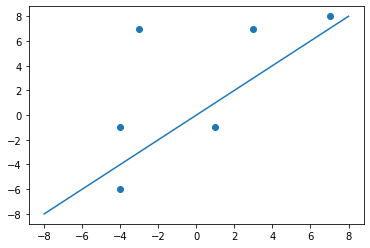

In [30]:
plt.scatter(X[0], X[1])
plt.plot([-8, 8], [-8, 8])

In [31]:
U, Σ, Vh = np.linalg.svd(X)

In [32]:
U[:,0:1].T @ X

array([[ -7.57023468,   7.19152763, -10.4085844 ,   0.37870705,
          2.83834972,  -4.61866347]])

In [33]:
trunc_svd = TruncatedSVD(n_components=1)
trunc_svd.fit_transform(X.T)

array([[ 7.57023468],
       [-7.19152763],
       [10.4085844 ],
       [-0.37870705],
       [-2.83834972],
       [ 4.61866347]])